In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm
import copy
from collections import Counter
from PIL import Image
from pathlib import Path
import warnings
from monai.utils import ensure_tuple, optional_import
from IPython.core.debugger import Tracer
from copy import deepcopy
from monai.transforms.compose import Transform
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.metrics import compute_roc_auc, compute_occlusion_sensitivity
from collections.abc import Sequence
from functools import partial
from typing import Dict, List, Optional, Sequence, Union

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import random
from resnet18 import resnet18
from sklearn.metrics import f1_score

ModuleNotFoundError: No module named 'monai'

In [2]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [3]:
data_dir = 'data/CellCycle'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
class_names.remove("PreprocessedTestData")
num_class = len(class_names)
all_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_files = [list(set([os.path.join(data_dir, class_name, x.split("_")[0]) 
                for x in os.listdir(os.path.join(data_dir, class_name))])) 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(all_files[0][0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 32266
Image dimensions: 66 x 66
Label names: ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase']
Label counts: [15, 14333, 8601, 68, 606, 8616, 27]


In [4]:
#weights = [1.0,1.1,1.4,1.5,1.3,1.4,1.0]

In [5]:
#flat_list = [item for sublist in all_files for item in sublist]

In [6]:
oversample = RandomOverSampler(random_state=42, sampling_strategy='all')

In [7]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []
X_train, testX, y_train, testY = train_test_split(image_file_list,image_label_list,test_size=test_frac, stratify=image_label_list, random_state=0)
trainX, valX, trainY, valY = train_test_split(X_train,y_train,test_size=valid_frac, stratify=y_train, random_state=1)
print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 26135 Validation count = 2904 Test count = 3227


In [8]:
Counter(trainY)

Counter({1: 11610, 5: 6978, 2: 6967, 4: 490, 3: 55, 6: 22, 0: 13})

In [9]:
trainX, trainY = oversample.fit_resample(np.asarray(trainX).reshape(-1, 1), np.asarray(trainY))

In [10]:
Counter(trainY)

Counter({1: 11610, 5: 11610, 2: 11610, 4: 11610, 3: 11610, 6: 11610, 0: 11610})

In [11]:
valX, valY = oversample.fit_resample(np.asarray(valX).reshape(-1, 1), np.asarray(valY))
#testX, testY = oversample.fit_resample(np.asarray(testX).reshape(-1, 1), np.asarray(testY))

In [12]:
trainX[np.in1d(trainX, testX)]

array([], shape=(0, 1), dtype='<U30')

In [13]:
print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 81270 Validation count = 9030 Test count = 3227


x = []
y = []
for i in flat_list:
    im = Image.open(i)
    Tracer()()
    width, height = im.size
    x.append(width)
    y.append(height)
    if width != 66 or height != 66:
        print(i)
plt.scatter(x, y)
plt.show()

In [14]:
class LoadImage(Transform):
    """
    Load common 2D image format (PNG, JPG, etc. using PIL) file or files from provided path.
    If loading a list of files, stack them together and add a new dimension as first dimension,
    and use the meta data of the first image to represent the stacked result.
    It's based on the Image module in PIL library:
    https://pillow.readthedocs.io/en/stable/reference/Image.html
    """

    def __init__(self, only_channels = []) -> None:
        self.only_channels = only_channels

    def __call__(self, name: Union[Sequence[Union[Path, str]], Path, str]):
        if isinstance(name, (np.ndarray, np.generic)):
            name = name[0]
        img_array = list()
        class_dir = os.path.dirname(name)
        sample_id = os.path.basename(name) + "_Ch"
        channels = [np.asarray(Image.open(os.path.join(class_dir, file))) / 255. for file in os.listdir(class_dir) if file.startswith(sample_id)]
        #Tracer()()
        image = np.stack(channels, axis = 2)
        image_RGB = image * 255.
        return Image.fromarray(np.uint8(image_RGB))

In [15]:
class ToTensorCustom(Transform):
    """
    Converts the input image to a tensor without applying any other transformations.
    """

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        Apply the transform to `img` and make it contiguous.
        """
        #img = np.asarray(img)
        #image = torch.from_numpy(copy.deepcopy(img))
        if torch.is_tensor(img):
            return img.contiguous().T
        #Tracer()()
        return torch.as_tensor(np.ascontiguousarray(img) / 255.).T

In [16]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
        
    def __call__(self, tensor):
        if torch.rand(1) < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

jurkat_mean = (0.1714, 0.0022, 0.3684)
jurkat_std = (0.0528, 0.0056, 0.0721)

train_transforms = transforms.Compose([
    LoadImage(),
    transforms.RandomCrop(64),
    transforms.RandomAffine(degrees=90, translate=(0.2,0.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((0,360)),
    ToTensorCustom(),
    transforms.RandomErasing(scale=(0.02,0.2), ratio=(0.3,0.9)),
    transforms.Normalize(jurkat_mean, jurkat_std)
    #AddGaussianNoise(0., 1., 0.3)
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [17]:
train_transforms = transforms.Compose([
    LoadImage(),
    #transforms.RandomCrop(64),
    #transforms.RandomAffine(degrees=90, translate=(0.2,0.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((0,360)),
    ToTensorCustom(),
    #transforms.RandomErasing(scale=(0.02,0.2), ratio=(0.3,0.9)),
    #transforms.Normalize(jurkat_mean, jurkat_std)
    AddGaussianNoise(0., 1., 0.3)
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [18]:
class JurkatDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = JurkatDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = JurkatDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = JurkatDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [19]:
def plot_heatmap_3_channels(heatmap):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,15))
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.imshow(heatmap[0])
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.imshow(heatmap[1])
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.imshow(heatmap[2])

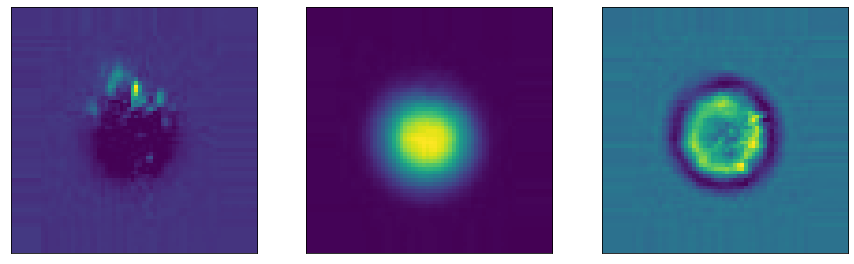

In [20]:
plot_heatmap_3_channels(test_ds[0][0])

In [26]:
class_names[torch.load('/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData/test_sample_0.pt')[1]]

'G2'

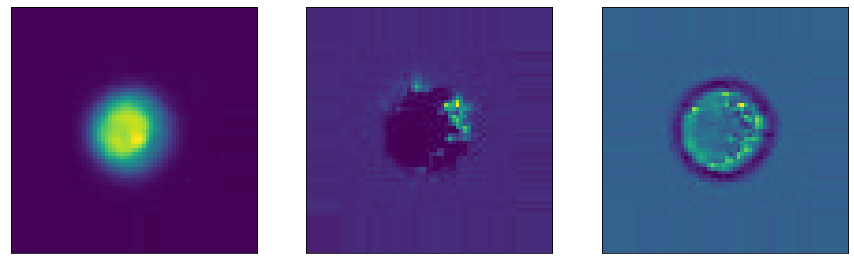

In [24]:
plot_heatmap_3_channels(torch.load('/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData/test_sample_0.pt')[0])

data_dir = "/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData"
for i,x in zip(np.arange(len(test_ds)), test_ds):
    #Tracer()()
    torch.save(x, os.path.join(data_dir, 'test_sample_{}.pt'.format(i)))
print("All test Data preprocessed and saved")

# Train

model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)

class_weights = torch.FloatTensor(weights).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)

class_weights = torch.FloatTensor(weights).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model.load_state_dict(torch.load('models/best_metric_model_jcd_oversampling_weightedCE.pth', map_location=torch.device(device))) 

epoch_num = 30
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_loss_valid_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            epoch_val_loss = 0
            step_val = 0
            for val_data in val_loader:
                step_val += 1
                val_images, val_labels = val_data[0].to(device).float(), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                val_loss = loss_function(model(val_images), val_labels)
                epoch_val_loss += val_loss.item()
            epoch_val_loss /= step_val
            epoch_loss_valid_values.append(epoch_val_loss)
            print(f"epoch {epoch + 1} average validation loss: {epoch_val_loss:.4f}")
            #Tracer()()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'models/best_metric_model_jcd_oversampling_weightedCE.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
y2 = epoch_loss_valid_values
plt.xlabel('epoch')
plt.plot(x, y, label="training error")
plt.plot(x, y2, label="validation error")
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

# Evaluating

In [75]:
model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)
model.load_state_dict(torch.load('models/best_metric_model_jurkat_oversampling_more_augm.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [76]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Anaphase     1.0000    1.0000    1.0000         1
          G1     0.8749    0.8444    0.8594      1433
          G2     0.7940    0.7663    0.7799       860
   Metaphase     0.7778    1.0000    0.8750         7
    Prophase     0.4068    0.7869    0.5363        61
           S     0.6251    0.6404    0.6327       862
   Telophase     1.0000    1.0000    1.0000         3

    accuracy                         0.7685      3227
   macro avg     0.7827    0.8626    0.8119      3227
weighted avg     0.7777    0.7685    0.7717      3227



In [78]:
from util import preprocess_image

In [79]:
files_to_interpret, data_loader = preprocess_image("data/CellCycle/PreprocessedTestData", 64, 2)

In [81]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in data_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Anaphase     1.0000    1.0000    1.0000         1
          G1     0.8724    0.8590    0.8657      1433
          G2     0.7839    0.7256    0.7536       860
   Metaphase     0.7000    1.0000    0.8235         7
    Prophase     0.3917    0.7705    0.5193        61
           S     0.6185    0.6357    0.6270       862
   Telophase     1.0000    1.0000    1.0000         3

    accuracy                         0.7626      3227
   macro avg     0.7666    0.8558    0.7985      3227
weighted avg     0.7717    0.7626    0.7656      3227



In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, caption=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix ' + caption
        else:
            title = 'Confusion matrix, without normalization ' + caption

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix" + caption)
    else:
        print('Confusion matrix, without normalization' + caption)

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.79064899 0.00697837 0.         0.00139567 0.20097697
  0.        ]
 [0.00348837 0.0244186  0.61976744 0.00232558 0.15232558 0.19767442
  0.        ]
 [0.         0.         0.         0.85714286 0.         0.14285714
  0.        ]
 [0.01639344 0.         0.18032787 0.08196721 0.68852459 0.03278689
  0.        ]
 [0.         0.15893271 0.16009281 0.00232019 0.01392111 0.66357309
  0.00116009]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


<AxesSubplot:title={'center':'Normalized confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

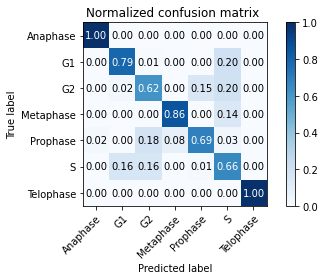

In [70]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True)

In [31]:
from statsmodels.stats.contingency_tables import mcnemar

In [89]:
def build_cont_table(
    model: nn.Module,
    test_loader,
    labels: Union[int, torch.Tensor],
) -> np.ndarray:
    model.eval()
    cont_table = {}
    y_true = list()
    y_pred = list()
    y_per_channel = {}
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
            pred = model(test_images).argmax(dim=1)
            for i_or in range(len(pred)):
                y_true.append(test_labels[i_or].item())
                y_pred.append(pred[i_or].item())
            for i in range(test_images[0].shape[0]):
                im_stack = []
                for image in test_images:
                    #Tracer()()
                    im = copy.deepcopy(image)
                    channel_shape = im[i].shape
                    arr = copy.deepcopy(im[i].flatten().detach())
                    random.shuffle(arr)
                    im[i] = arr.reshape(channel_shape)
                    im_stack.append(im.unsqueeze(0))
                im_stack = torch.cat(im_stack)
                probabilities = model(im_stack).argmax(dim=1)
                y_ch_pred = list()
                for i_ch in range(len(probabilities)):
                    y_ch_pred.append(probabilities[i_ch].item())
                channel_to_shuffle = 'shuffled_channel_{}'.format(i)
                if channel_to_shuffle not in y_per_channel:
                    y_per_channel[channel_to_shuffle] = np.empty(0, dtype=np.float32)
                y_per_channel[channel_to_shuffle] = np.concatenate((y_per_channel[channel_to_shuffle],np.asarray(y_ch_pred)))
        cont_table['original'] = np.asarray(y_pred)==np.asarray(y_true)
        for key, value in y_per_channel.items():
            cont_table[key] = np.asarray(value)==np.asarray(y_true)
        return y_per_channel, cont_table

In [90]:
y_per_ch, table = build_cont_table(model, test_loader, test_labels)

In [91]:
y_per_ch

{'shuffled_channel_0': array([5., 1., 2., ..., 1., 1., 1.]),
 'shuffled_channel_1': array([1., 1., 2., ..., 1., 5., 3.]),
 'shuffled_channel_2': array([1., 1., 1., ..., 1., 1., 5.])}

In [95]:
channel_to_shuffle = 'shuffled_channel_0'

In [74]:
f1_score(y_true, y_per_ch.get(channel_to_shuffle), None)

NameError: name 'y_per_ch' is not defined

In [79]:
# original vs shuffled_channel_0
yes_yes = np.count_nonzero(np.logical_and(table.get('original'), table.get(channel_to_shuffle)))
yes_no = np.count_nonzero(np.logical_and((table.get('original') != table.get(channel_to_shuffle)), table.get('original')))
no_yes = np.count_nonzero(np.logical_and((table.get('original') != table.get(channel_to_shuffle)), table.get(channel_to_shuffle)))
no_no = np.count_nonzero(np.logical_and(np.logical_not(table.get('original')), np.logical_not(table.get(channel_to_shuffle))))

In [80]:
t = [[yes_yes, yes_no],[no_yes, no_no]]

In [81]:
t

[[1565, 928], [223, 511]]

In [82]:
result = mcnemar(t, exact=True)

In [83]:
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=223.000, p-value=0.000


In [84]:
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

Different proportions of errors (reject H0)


In [83]:
import random
from collections.abc import Sequence
from functools import partial
from typing import Optional, Union
from scipy.special import softmax

def pixel_permutation_per_channel(
    model: nn.Module,
    images: torch.Tensor,
    labels: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baselines = softmax(model(images), axis=1).detach()[np.arange(len(labels)),labels]
    #iterate through the channels
    res = []
    for i in range(images[0].shape[0]):
        #iterate through the images in batch
        im_stack = []
        for image in images:
            plot_heatmap_3_channels(image.detach().numpy())
            im = copy.deepcopy(image)
            channel_shape = im[i].shape
            #arr = copy.deepcopy(im[i].flatten().detach())
            #random.shuffle(arr)
            #im[i] = arr.reshape(channel_shape)
            arr = np.asarray(im[i].flatten())
            np.random.shuffle(arr)
            im[i] = torch.Tensor(arr.reshape(channel_shape))
            plot_heatmap_3_channels(im)
            Tracer()()
            im_stack.append(im.unsqueeze(0))
            #Tracer()()
        im_stack = torch.cat(im_stack) # batch with shuffled i channel
        #Tracer()()
        probabilities = softmax(model(im_stack), axis=1)
        probs_for_label = probabilities.detach()[np.arange(len(labels)),labels]
        predicted_labels = torch.argmax(probabilities, dim=1)
        # save channel, probability for the ground truth label, ground truth label, 
        # label which was predicted with max probability after shuffeling of the i^th channel
        for (prob,label,predicted_label) in zip(probs_for_label,labels,predicted_labels):
            res.append({"channel": i, "prob": prob, "true_label": label,"predicted_label": predicted_label})
    return res

def channel_permutation(
    model: nn.Module,
    images: torch.Tensor,
    labels: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baselines = softmax(model(images), axis=1).detach()[np.arange(len(labels)),labels]
    #plot_heatmap_3_channels(image.detach().numpy()[0])
    im_stack = []
    for image in images:
        plot_heatmap_3_channels(image.detach().numpy())
        im = copy.deepcopy(image)
        im = im[torch.randperm(im.size()[0]),:,:]
        plot_heatmap_3_channels(im)
        im_stack.append(im.unsqueeze(0))
        Tracer()()
    im_stack = torch.cat(im_stack)
    #plot_heatmap_3_channels(im.detach().numpy()[0])
    probabilities = softmax(model(im_stack), axis=1)
    probs_for_label = probabilities.detach()[np.arange(len(labels)),labels]
    #Tracer()()
    predicted_labels = torch.argmax(probabilities, dim=1)
    return baselines, probs_for_label, predicted_labels

/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


> <ipython-input-61-ae773f6c8c3b>(32)pixel_permutation_per_channel()
     30             plot_heatmap_3_channels(im)
     31             Tracer()()
---> 32             im_stack.append(im.unsqueeze(0))
     33             #Tracer()()
     34         im_stack = torch.cat(im_stack) # batch with shuffled i channel

ipdb> q
Exiting Debugger.


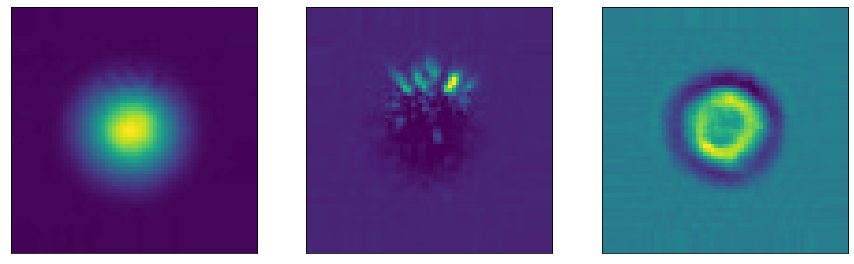

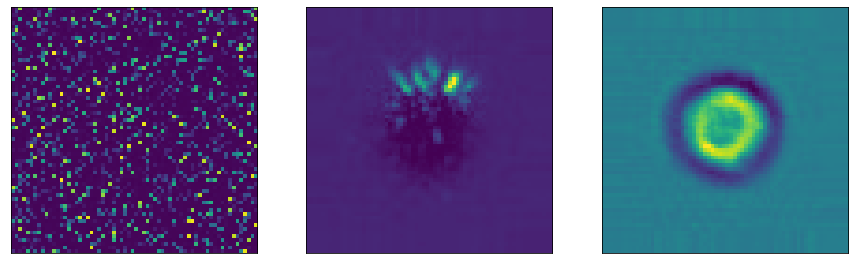

In [62]:
results = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        results.append(pixel_permutation_per_channel(model, test_images, test_labels))

/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


> <ipython-input-83-ae773f6c8c3b>(55)channel_permutation()
     53     #plot_heatmap_3_channels(image.detach().numpy()[0])
     54     im_stack = []
---> 55     for image in images:
     56         plot_heatmap_3_channels(image.detach().numpy())
     57         im = copy.deepcopy(image)

ipdb> q
Exiting Debugger.


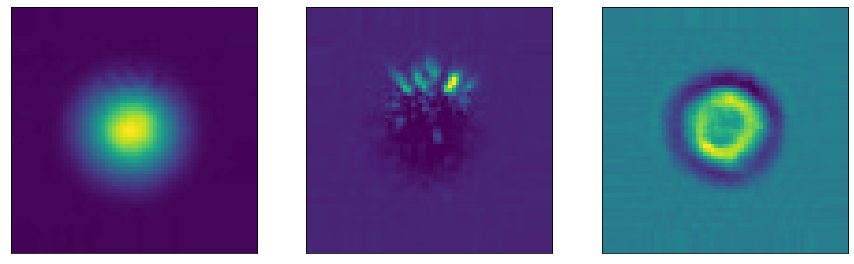

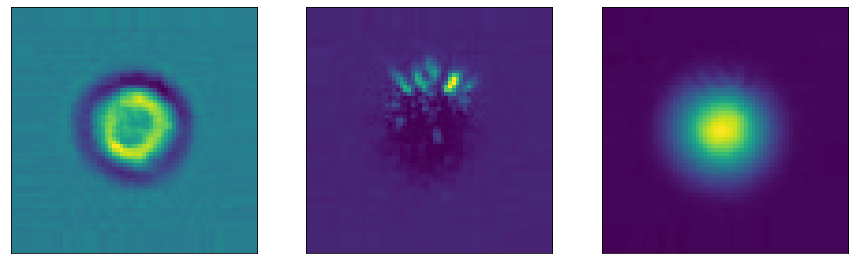

In [86]:
baselines = []
results_y = []
results_y_predicted = []
probs = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        baseline, probs_for_label, predicted_labels = channel_permutation(model, test_images, test_labels)
        #Tracer()()
        baselines += baseline
        probs += probs_for_label
        results_y += test_labels
        results_y_predicted += predicted_labels
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.asarray(baselines, dtype=np.float32), np.asarray(probs, dtype=np.float32), s=2)
ax.set_xlabel('Baseline')
ax.set_ylabel('Probability after channel shuffle')
plt.show()
plot_confusion_matrix(y_true=np.asarray(results_y, dtype=np.int), y_pred=np.asarray(results_y_predicted, dtype=np.int), classes=class_names, normalize=True, caption = " shuffled channels")

In [74]:
from itertools import groupby
from collections import defaultdict

def key_func(k): 
    return k['channel']

ress = [item for sublist in results for item in sublist]
ress = sorted(ress, key=key_func)
groups = []
y_per_channel = defaultdict(list)
y_predicted_per_channel = defaultdict(list)
for key, value in groupby(ress, key_func): 
    groups.append(list(value)) 
    y_per_channel[key] = [int(sub['true_label']) for sub in groups[0]]
    y_predicted_per_channel[key] = [int(sub['predicted_label']) for sub in groups[0]]

Normalized confusion matrixchannel 0
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 8.83461270e-01 1.39567341e-02 2.58199581e-02
  2.79134682e-03 7.32728542e-02 6.97836706e-04]
 [1.97674419e-02 2.93023256e-01 2.20930233e-01 1.33720930e-01
  3.25581395e-02 2.98837209e-01 1.16279070e-03]
 [1.42857143e-01 2.85714286e-01 0.00000000e+00 5.71428571e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.19672131e-02 1.47540984e-01 1.96721311e-01 1.96721311e-01
  1.31147541e-01 2.45901639e-01 0.00000000e+00]
 [1.16009281e-03 6.05568445e-01 3.82830626e-02 8.23665893e-02
  9.28074246e-03 2.63341067e-01 0.00000000e+00]
 [0.00000000e+00 6.66666667e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.33333333e-01]]
Normalized confusion matrixchannel 1
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 8.83461270e-01 1.39567341e-0

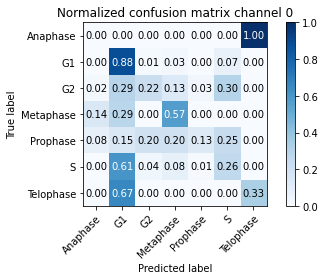

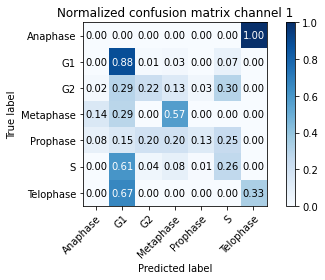

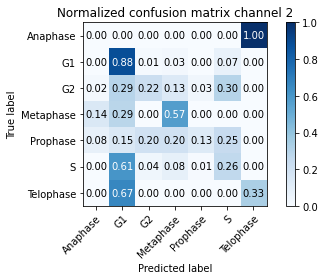

In [75]:
for (k,v), (k2,v2) in zip(y_per_channel.items(), y_predicted_per_channel.items()):
    plot_confusion_matrix(v, v2, classes=class_names, normalize=True, caption = "channel " + str(k))

In [30]:
from captum.attr import GuidedGradCam, DeepLift, Saliency, DeepLiftShap, GradientShap, InputXGradient, GradientShap, InputXGradient

In [31]:
test_sample = torch.load("/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData/test_sample_0.pt")

In [34]:
dl= DeepLift(model)

In [37]:
heatmap = dl.attribute(torch.unsqueeze(test_sample[0].float(), 0), target=int(test_sample[1]))[0]

In [73]:
heatmap[0].detach().numpy()

array([[ 4.5987763e-04, -7.5133384e-04, -6.8677438e-04, ...,
        -8.9895162e-05,  1.1592875e-04, -1.1395423e-04],
       [-2.9949303e-04, -3.0430686e-04,  1.0270545e-04, ...,
         7.7942146e-05,  3.6868438e-04, -2.3168909e-04],
       [-6.9507783e-05, -2.2864775e-04,  2.3034998e-04, ...,
        -3.1599549e-05,  5.7870313e-04, -4.5493554e-05],
       ...,
       [ 2.5344529e-04,  3.2386929e-04,  2.7108542e-04, ...,
         3.8112959e-04,  4.7690446e-05, -2.1069271e-04],
       [-1.5525568e-04,  2.5674468e-04,  3.5153015e-04, ...,
         4.9903989e-04, -2.6952557e-04,  3.3807647e-04],
       [-1.0046336e-04, -3.9139824e-05, -1.2572677e-04, ...,
        -1.0924267e-04, -6.6718948e-04,  6.1820651e-04]], dtype=float32)

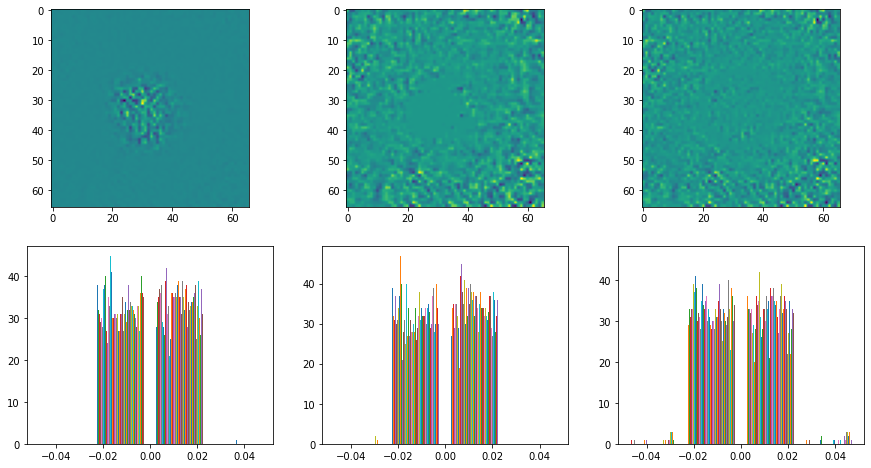

In [76]:
fig, axs = plt.subplots(2, len(heatmap), figsize=(15, 8))
axs = axs.ravel()
for (i, h) in zip(np.arange(len(heatmap)), heatmap):
    h = h.detach().numpy()
    #Tracer()()
    binwidth = 0.025
    lim = np.ceil(np.abs(h).max() / binwidth) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axs[i].imshow(h)
    axs[i + len(heatmap)].hist(h, bins=bins)

In [47]:
dl= DeepLift(model)

In [51]:
heatmaps = dl.attribute(torch.unsqueeze(test_sample[0].float(), 0), target=int(test_sample[1]))